In [34]:
# Basic libraries
import torch
import torch.nn as n
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from typing import List
import torch.optim as optim
from tqdm import tqdm
from omegaconf import OmegaConf

In [35]:
os.chdir("../")
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder, VanillaDecoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *
from osgen.loss import *
from osgen.pipeline import *

In [36]:
# Load config
cfg = OmegaConf.load("/root/BiOSGen/configs/train_config.yml")
print(cfg.verbose)

True


In [37]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


In [38]:
idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
)

idx_dst = 60 # torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[idx_dst]))),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

idx_src:  20
idx_dst:  60


In [39]:
# Initialize your pipeline
pipeline = OSGenPipeline()

# Load the checkpoint file (a state_dict)
checkpoints = torch.load("/root/BiOSGen/checkpoints/main/pipeline_full_best_100_epoch_512.pth")


/tmp/ipykernel_27406/3007567791.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load("/root/BiOSGen/checkpoints/main/pipeline_full_best_100_epoch_512

In [40]:
checkpoint_keys = set(checkpoints['model_state_dict'].keys())
pipeline_keys = set(pipeline.state_dict().keys())

print("Keys only in checkpoint:", checkpoint_keys - pipeline_keys)
print("Keys only in pipeline:", pipeline_keys - checkpoint_keys)
print("Common keys:", checkpoint_keys & pipeline_keys)

# Check for shape mismatches in common keys
print("\nShape mismatches:")
for key in checkpoint_keys & pipeline_keys:
    if checkpoints['model_state_dict'][key].shape != pipeline.state_dict()[key].shape:
        print(f"{key}: checkpoint shape = {checkpoints['model_state_dict'][key].shape}, pipeline shape = {pipeline.state_dict()[key].shape}")

Keys only in checkpoint: {'unet.input_blocks.8.0.post_adain.channel_reducer.weight', 'unet.output_blocks.0.0.post_adain.channel_reducer.weight', 'unet.output_blocks.7.0.pre_adain.channel_reducer.weight', 'unet.input_blocks.10.0.post_adain.channel_reducer.bias', 'unet.output_blocks.6.0.post_adain.channel_reducer.weight', 'unet.output_blocks.1.0.pre_adain.channel_reducer.weight', 'unet.output_blocks.9.0.pre_adain.channel_reducer.bias', 'unet.output_blocks.2.0.post_adain.channel_reducer.bias', 'unet.output_blocks.8.0.post_adain.channel_reducer.bias', 'unet.output_blocks.2.0.pre_adain.channel_reducer.weight', 'unet.output_blocks.4.0.pre_adain.channel_reducer.bias', 'unet.output_blocks.5.0.pre_adain.channel_reducer.weight', 'unet.output_blocks.4.0.post_adain.channel_reducer.weight', 'unet.input_blocks.7.0.post_adain.channel_reducer.weight', 'unet.output_blocks.10.0.pre_adain.channel_reducer.bias', 'unet.input_blocks.11.0.post_adain.channel_reducer.weight', 'unet.input_blocks.10.0.post_adain

In [42]:
checkpoint_keys = set(checkpoints['model_state_dict'].keys())
pipeline_keys = set(pipeline.state_dict().keys())

print("Keys only in checkpoint:", checkpoint_keys - pipeline_keys)
print("Keys only in pipeline:", pipeline_keys - checkpoint_keys)
print("Common keys:", checkpoint_keys & pipeline_keys)

# Check for shape mismatches in common keys
print("\nShape mismatches:")
for key in checkpoint_keys & pipeline_keys:
    if checkpoints['model_state_dict'][key].shape != pipeline.state_dict()[key].shape:
        print(f"{key}: checkpoint shape = {checkpoints['model_state_dict'][key].shape}, pipeline shape = {pipeline.state_dict()[key].shape}")

Keys only in checkpoint: set()
Keys only in pipeline: set()
Common keys: {'style_extractor.resnet.6.3.bn1.running_mean', 'style_extractor.resnet.5.1.bn1.running_var', 'unet.middle_block.2.resblock.emb_layers.1.weight', 'style_extractor.resnet.6.0.downsample.1.num_batches_tracked', 'unet.input_blocks.8.0.resblock.out_norm.bias', 'encoder.decoder.0.1.running_var', 'unet.output_blocks.10.0.resblock.out_norm.weight', 'unet.output_blocks.4.0.pre_adain.channel_reducer.bias', 'style_extractor.resnet.6.0.downsample.1.running_var', 'style_extractor.resnet.6.4.bn2.bias', 'style_extractor.resnet.7.1.bn3.bias', 'style_extractor.resnet.4.0.bn3.num_batches_tracked', 'style_extractor.resnet.6.4.bn2.num_batches_tracked', 'style_extractor.resnet.5.3.bn2.running_mean', 'unet.input_blocks.6.0.op.weight', 'style_extractor.resnet.6.4.conv2.weight', 'style_extractor.resnet.6.3.conv2.weight', 'unet.input_blocks.10.0.resblock.emb_layers.1.bias', 'style_extractor.resnet.7.2.bn1.num_batches_tracked', 'encoder.d

In [43]:
pipeline.load_state_dict(checkpoints['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Hyperparameters
verbose = cfg.verbose
num_epochs = 10
batch_size = cfg.batch_size
lr = cfg.lr
optimizer = optim.AdamW([p for p in pipeline.parameters() if p.requires_grad], 
                        lr=cfg.optimizer.params.lr, weight_decay=cfg.optimizer.params.weight_decay, eps=cfg.optimizer.params.eps)

channels = cfg.channels
height = cfg.height
width = cfg.width
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lambda_content = cfg.lambda_content
lambda_style = cfg.lambda_style

# Training loop
# Put on training mode
pipeline.train()
requires_grad = True

# Early stopping parameters
early_stopping_patience = cfg.early_stopping_patience
epochs_without_improvement = 0
best_loss = float("inf")

# Convergence check parameters
convergence_patience = 5  # Number of epochs to check for convergence
convergence_threshold = 0.001  # Minimum relative change in loss to continue training
loss_history = []  # Keep track of recent losses

# Save losses
losses = []
content_losses = []
style_losses = []

# Switch to main training with bfloat16
for epoch in tqdm(range(num_epochs)):
    # print(f"Epoch {epoch+1}/{num_epochs}")
    avg_loss = []
    content_loss = []
    style_loss = []

    for i, (src, dst) in enumerate(zip(patches_src, patches_dst)):
        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        decoded = pipeline(src_tensor, dst_tensor, timesteps)

        # Handle gradients issues
        requires_grad = decoded.requires_grad
        # print(requires_grad)
        if not requires_grad:
            break

        # Compute loss
        content_l, style_l, total_loss = pipeline.compute_loss(src_tensor, dst_tensor, decoded, lambda_content, lambda_style)

        # Break if total_loss is NaN
        if torch.isnan(total_loss):
            print(f"NaN loss at epoch {epoch+1}, batch {i+1}")
            break

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(patches_src)}, "
                f"Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}, "
                f"Total Loss: {total_loss.item():.4f}")

        avg_loss.append(total_loss.item())
        content_loss.append(content_l.item())
        style_loss.append(style_l.item())

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

Text(0.5, 1.0, 'Generated Image')

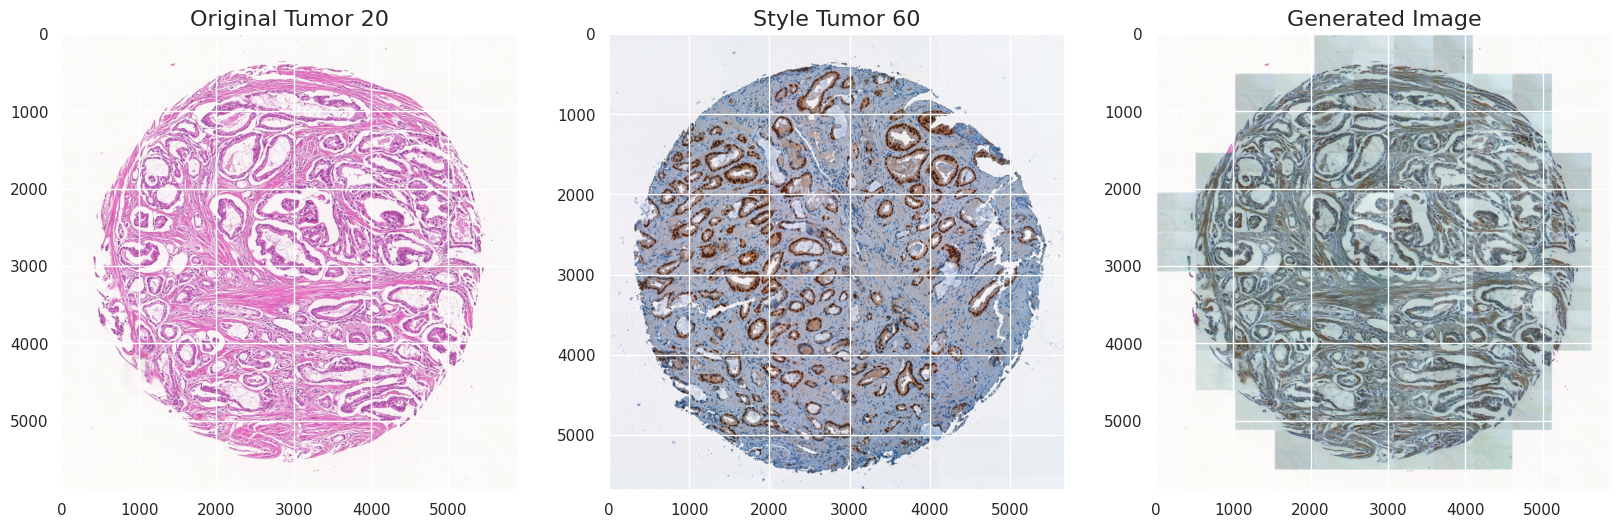

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(20, 15))  # 1x5 grid

# Plot original source image
axes[0].imshow(np.array(Image.open(tree_src.antibodies[idx_src])), cmap='viridis')
axes[0].set_title(f'Original Tumor {idx_src}', fontsize=16)

# Plot original destination image
axes[1].imshow(np.array(Image.open(tree_dst.antibodies[idx_dst])), cmap='viridis')
axes[1].set_title(f'Style Tumor {idx_dst}', fontsize=16)

# Plot decoded image
gen = []
with torch.no_grad():
    for i in range(len(patches_src)):
        # Assign idx_src and idx_dst to the patches
        src = patches_src[i]
        dst = patches_dst[torch.randint(0, len(patches_dst), (1,)).item()]

        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        out = pipeline(src_tensor, dst_tensor, timesteps)
        gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

generated = PatchesUtilities.replace_patches_in_image(
    original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask=PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
    generated_patches=gen
)
axes[2].imshow(generated, cmap='viridis')
axes[2].set_title(f'Generated Image', fontsize=16)

In [60]:
import numpy as np
from typing import List
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def get_image_patches_full(
    image: np.ndarray, 
    patch_size: int = 512,
    is_visualize: bool = False
) -> List[np.ndarray]:
    h, w, _ = image.shape

    # Calculate padding only if needed
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size
    image_padded = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant', constant_values=255)

    if is_visualize:
        fig, ax = plt.subplots()
        ax.imshow(Image.fromarray(image_padded))

    patches = []
    for y in range(0, image_padded.shape[0], patch_size):
        for x in range(0, image_padded.shape[1], patch_size):
            patch = image_padded[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
            
            if is_visualize:
                rect = Rectangle((x, y), patch_size, patch_size, linewidth=1, edgecolor='green', facecolor='none')
                ax.add_patch(rect)

    if is_visualize:
        plt.title(f"Total patches: {len(patches)}")
        plt.show()

    return patches

def replace_patches_in_image_full(
    original_image: np.ndarray,
    generated_patches: List[np.ndarray],
    patch_size: int = 512
) -> np.ndarray:
    h, w, _ = original_image.shape

    # Compute padding if needed
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size

    image_padded = np.pad(original_image, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant', constant_values=255)

    # Create a copy to modify
    reconstructed_image = image_padded.copy()

    # Replace patches in the same order as full-grid extraction
    patch_idx = 0
    for y in range(0, image_padded.shape[0], patch_size):
        for x in range(0, image_padded.shape[1], patch_size):
            if patch_idx < len(generated_patches):
                reconstructed_image[y:y + patch_size, x:x + patch_size] = generated_patches[patch_idx]
                patch_idx += 1
            else:
                print("Warning: Not enough patches to fill the image. Some areas remain unchanged.")
                break

    # Remove padding to return to original size
    return reconstructed_image[:h, :w]



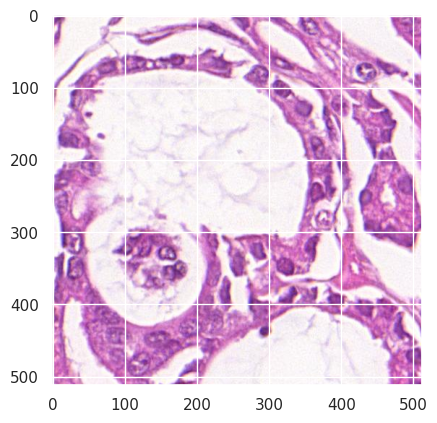

In [66]:
plt.imshow(get_image_patches(
    image=np.array(Image.open(tree_src.antibodies[idx_src])),
)[16])

In [71]:
idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = get_image_patches_full(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
)

idx_dst = 60 # torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = get_image_patches_full(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

idx_src:  20
idx_dst:  60


Text(0.5, 1.0, 'Generated Image')

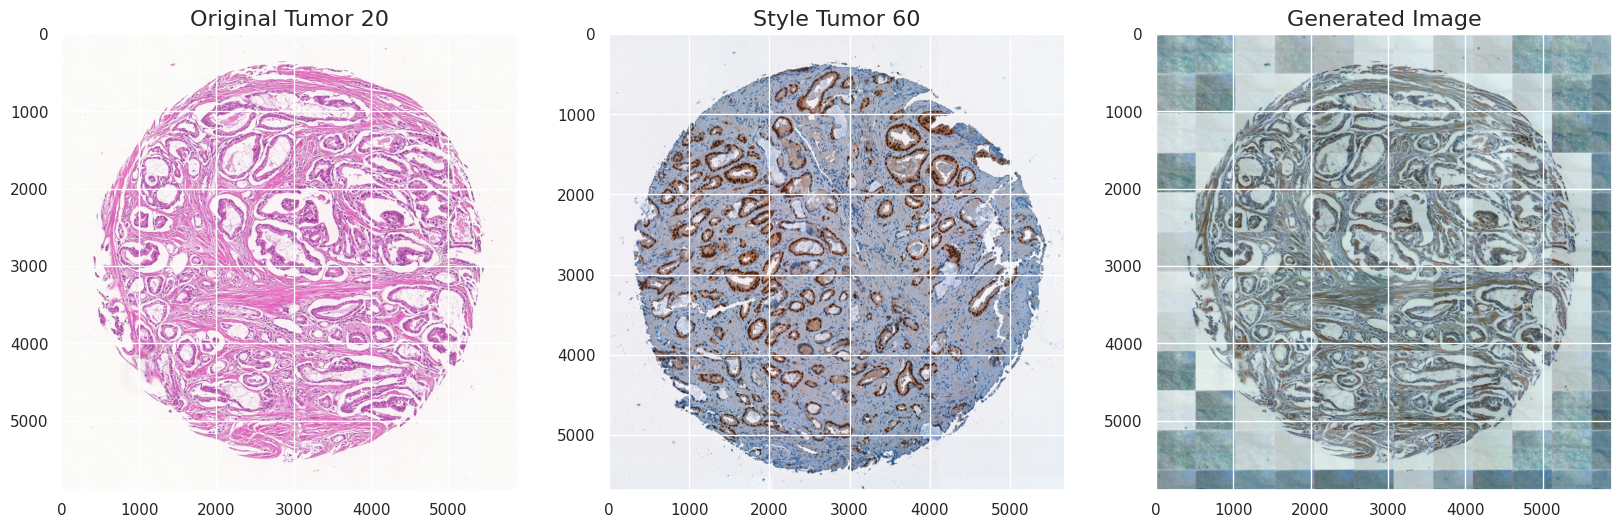

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(20, 15))  # 1x5 grid

# Plot original source image
axes[0].imshow(np.array(Image.open(tree_src.antibodies[idx_src])), cmap='viridis')
axes[0].set_title(f'Original Tumor {idx_src}', fontsize=16)

# Plot original destination image
axes[1].imshow(np.array(Image.open(tree_dst.antibodies[idx_dst])), cmap='viridis')
axes[1].set_title(f'Style Tumor {idx_dst}', fontsize=16)

# Plot decoded image
gen = []
with torch.no_grad():
    for i in range(len(patches_src)):
        # Assign idx_src and idx_dst to the patches
        src = patches_src[i]
        dst = patches_dst[torch.randint(0, len(patches_dst), (1,)).item()]

        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        out = pipeline(src_tensor, dst_tensor, timesteps)
        gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

generated = replace_patches_in_image_full(
    original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
    generated_patches=gen
)
axes[2].imshow(generated, cmap='viridis')
axes[2].set_title(f'Generated Image', fontsize=16)